<a href="https://colab.research.google.com/github/Mahabuburr/444/blob/master/Paddy_leaf_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tf-nightly-gpu-2.0-preview
!pip install tf-hub-nightly
!pip install tensorflow==2.0.0-alpha

# Install TF Hub for TF2
!pip install 'tensorflow-hub == 0.5'

ERROR: Could not find a version that satisfies the requirement tf-nightly-gpu-2.0-preview (from versions: none)
ERROR: No matching distribution found for tf-nightly-gpu-2.0-preview
     |████████████████████████████████| 112kB 9.3MB/s 
     |████████████████████████████████| 79.9MB 103kB/s 
     |████████████████████████████████| 3.0MB 47.0MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 419kB 45.8MB/s 
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0
     |████████████████████████████████| 81kB 6.4MB/s 
  Found existing installation: tensorflow-hub 0.10.0
    Uninstalling tensorflow-hub-0.10.0:
      Successfully uninstalled tensorflow-hub-0.10.0


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
#tf.enable_eager_execution()

import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
#from keras import optimizers

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [ ]:
# verify TensorFlow version

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.0.0-alpha0
Eager mode:  True
Hub version:  0.5.0
GPU is NOT AVAILABLE


In [ ]:

zip_file = tf.keras.utils.get_file(origin='https://github.com/AveyBD/rice-leaf-diseases-detection/raw/master/rice-leaf.zip', 
                                   fname='rice-leaf.zip', extract=True)
!unzip /content/rice-leaf-diseases-detection-master/rice-leaf.zip;

unzip:  cannot find or open /content/rice-leaf-diseases-detection-master/rice-leaf.zip, /content/rice-leaf-diseases-detection-master/rice-leaf.zip.zip or /content/rice-leaf-diseases-detection-master/rice-leaf.zip.ZIP.


In [ ]:
data_dir = os.path.join(os.path.dirname(zip_file), '/content/rice')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

In [ ]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"

In [ ]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))

total images for training : /content/rice/train : 157files
total images for validation : /content/rice/validation : 84files


In [ ]:
!!wget https://github.com/AveyBD/rice-leaf-diseases-detection/archive/master.zip
!unzip master.zip;

Archive:  master.zip
e56f0a072757582b0c8e6db762a720860b8da342
replace rice-leaf-diseases-detection-master/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace rice-leaf-diseases-detection-master/Rice_Leaf_Detection.ipynb? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace rice-leaf-diseases-detection-master/Rice_Leaf_Detection_Colab.ipynb? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import json

with open('rice-leaf-diseases-detection-master/classes.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
    
print (classes)

['Bacterial_leaf_blight', 'blast', 'brownspot']


In [ ]:
print('Number of classes:',len(classes))

Number of classes: 3


In [ ]:
module_selection = ("inception_v3", 299, 2048) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

BATCH_SIZE = 64 #@param {type:"integer"

Using https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2 with input size (299, 299) and output dimension 2048


In [ ]:
# Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 84 images belonging to 3 classes.
Found 157 images belonging to 3 classes.


In [ ]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape=[FV_SIZE])

In [ ]:
do_fine_tuning = False #@param {type:"boolean"}
if do_fine_tuning:
  feature_extractor.trainable = True
  # unfreeze some layers of base network for fine-tuning
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False

In [ ]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
#model.build((None,)+IMAGE_SIZE+(3,))

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 22,853,411
Trainable params: 1,050,627
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:

LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [ ]:
EPOCHS=30 #@param {type:"integer"}

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/30
2/2 [==============================] - 39s 19s/step - loss: 2.5721 - accuracy: 0.4194 - val_loss: 4.5004 - val_accuracy: 0.0000e+00
Epoch 2/30
2/2 [==============================] - 36s 18s/step - loss: 1.7417 - accuracy: 0.6452 - val_loss: 1.5373 - val_accuracy: 0.6719
Epoch 3/30
2/2 [==============================] - 43s 21s/step - loss: 1.2174 - accuracy: 0.5547 - val_loss: 0.6793 - val_accuracy: 0.6875
Epoch 4/30
2/2 [==============================] - 33s 16s/step - loss: 0.8805 - accuracy: 0.5161 - val_loss: 0.9844 - val_accuracy: 0.5469
Epoch 5/30
2/2 [==============================] - 43s 21s/step - loss: 0.4961 - accuracy: 0.7969 - val_loss: 1.2761 - val_accuracy: 0.5469
Epoch 6/30
2/2 [==============================] - 36s 18s/step - loss: 0.5447 - accuracy: 0.7957 - val_loss: 1.4303 - val_accuracy: 0.6406
Epoch 7/30
2/2 [==============================] - 33s 16s/step - loss: 0.6695 - accuracy: 0.8280 - val_loss: 1.1980 - val_accuracy: 0.6406
Epoch 8/30
2/2 [=======

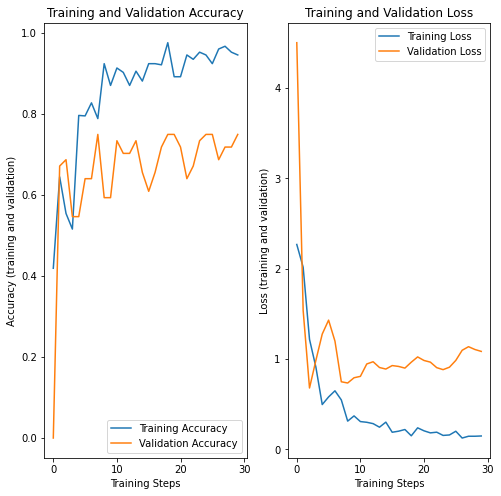

In [ ]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [ ]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: brownspot, file: brownspot/brownspot_rotated_015.jpg
PREDICTED: class: brownspot, confidence: 0.961196


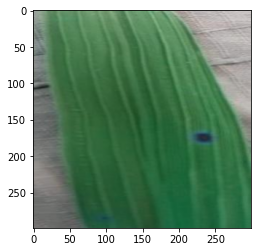

<Figure size 432x288 with 0 Axes>

SOURCE: class: brownspot, file: brownspot/brownspot_rotated_001.jpg
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.728176


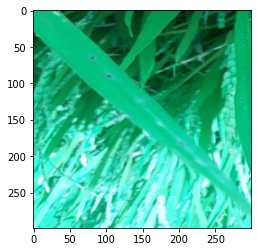

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_001.jpg
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.973519


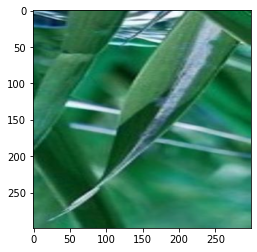

<Figure size 432x288 with 0 Axes>

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_016.png
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.512845


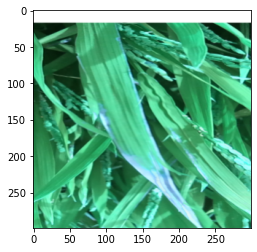

<Figure size 432x288 with 0 Axes>

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_038.JPG
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.970872


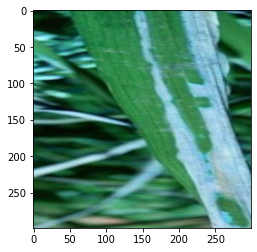

<Figure size 432x288 with 0 Axes>

In [ ]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()